# QA Raster to H3 conversion and test data

This notebooks measures the amount of error we get from transforming raster data to H3 resolution 6 for cotton production, water risk and impact on a test area (India).  
It also exports test data (as geojson and csv) for further testing against results from database queries. 

In [ ]:
# Install if needed
#!pip install h3 --user
#!pip install h3ronpy --user

In [1]:
# Import libraries
import rasterio as rio
import rasterio.plot
from h3ronpy import raster

In [2]:
prod_raster = "../../datasets/processed/h3_test/cotton_production_ind.tif"

test_area = (65, 4, 100, 40)

In [3]:
# Check if raster (production) has all the info right
!gdalinfo $prod_raster

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/h3_test/cotton_production_ind.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666650000013,83.097781811000004)
Pixel Size = (0.083333340000000,-0.083333340000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916667,  83.0977818) (179d59'30.00"W, 83d 5'52.01"N)
Lower Left  (-179.9916667, -55.9022293) (179d59'30.00"W, 55d

## Production map  
Process is:  
- Open and visualize raster data
- Transform to H3 (resolution 6) geodataframe
- Compare mean and std. dev. of raster and H3 values

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 1668, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -179.99166665,
       0.0, -0.08333334, 83.097781811), 'tiled': False, 'interleave': 'band'}


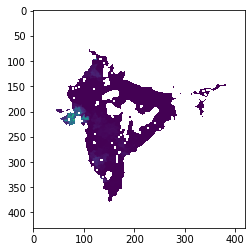

,h3index,value,geometry
0,595641277383442431,314.101593,"POLYGON ((74.77739 30.52301, 74.80568 30.28560..."
1,595557989377638399,0.001375,"POLYGON ((80.85161 26.74488, 80.85750 26.51828..."
2,596176000811794431,147.633499,"POLYGON ((76.37923 15.72577, 76.38236 15.96687..."
3,595649583850192895,3434.707764,"POLYGON ((70.43899 21.79230, 70.47752 21.58064..."
4,595540775148716031,4.291802,"POLYGON ((81.92629 17.23684, 81.93420 17.48327..."


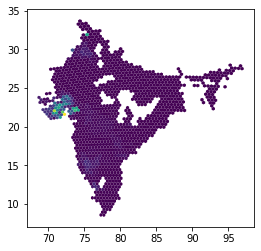

In [4]:
with rio.open(prod_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=4,
        nodata_value=int(src.profile["nodata"]),
        compacted=False,
    )

gdf.plot("value")
gdf.head()

Calculate mean and standard deviation values for the raster data

In [27]:
src = rio.open(prod_raster)
window = rio.windows.from_bounds(*test_area, src.transform)

array = src.read(window=window)
prod_df = array[0].ravel()
rst_m = round(prod_df[prod_df > 0].mean(), 2)
rst_s = round(prod_df[prod_df > 0].std(), 2)

And for the H3 data

In [14]:
h3_m = round(gdf["value"].mean(), 2)
h3_s = round(gdf["value"].std(), 2)

In [29]:
print(f"Raster PRODUCTION mean value: {rst_m:.2f}  std. dev.:{rst_s:.2f}")
print(f"H3 map PRODUCTION mean value: {h3_m}  std. dev.:{h3_s}")

Raster PRODUCTION mean value: 144.52  std. dev.:521.12
H3 map PRODUCTION mean value: 150.94  std. dev.:560.04


## Risk map

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 1668, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -179.99166664999998,
       0.0, -0.08333334, 83.08834447000001), 'tiled': False, 'interleave': 'band'}


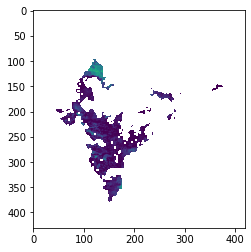

,h3index,value,geometry
0,596167376517464063,0.005649,"POLYGON ((76.91709 10.26087, 76.92060 10.50475..."
1,595652616097103871,0.000758,"POLYGON ((69.95694 24.38554, 69.99855 24.16575..."
2,595532159444320255,0.299519,"POLYGON ((84.98547 26.64909, 84.99640 26.88171..."
3,595559630055145471,0.952000,"POLYGON ((76.40268 29.23269, 76.42464 28.99841..."
4,595651843002990591,0.000818,"POLYGON ((69.05924 24.26639, 69.10366 24.04729..."


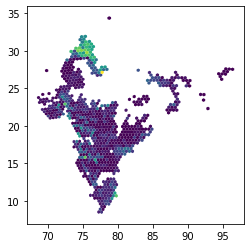

In [30]:
risk_raster = "../../datasets/processed/h3_test/wr_cotton_india.tif"

with rio.open(risk_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=4,
        nodata_value=int(src.profile["nodata"]),
        compacted=False,
    )

gdf.plot("value")
# gdf['h3index'] = gdf['h3index'].apply(hex)
gdf.head()

In [33]:
src = rio.open(risk_raster)
window = rio.windows.from_bounds(*test_area, src.transform)

array = src.read(window=window)
risk_df = array[0].ravel()
rst_m = round(risk_df[risk_df > 0].mean(), 3)
rst_s = round(risk_df[risk_df > 0].std(), 3)

h3_m = round(gdf["value"].mean(), 3)
h3_s = round(gdf["value"].std(), 3)

print(f"Raster RISK mean value: {rst_m:.3f}  std. dev.:{rst_s:.3f}")
print(f"H3 map RISK mean value: {h3_m}  std. dev.:{h3_s}")

Raster RISK mean value: 0.161  std. dev.:0.222
H3 map RISK mean value: 0.165  std. dev.:0.222


## Impact map

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 1668, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -179.99166665,
       0.0, -0.08333334, 83.097781811), 'tiled': False, 'interleave': 'band'}


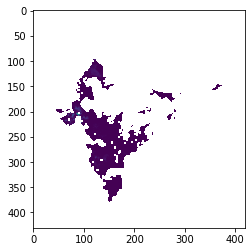

,h3index,value,geometry
0,595541041436688383,0.000001,"POLYGON ((81.74298 18.34293, 81.75076 18.58794..."
1,596191316665171967,0.000064,"POLYGON ((79.01816 12.43928, 79.02347 12.68569..."
2,595541445163614207,0.000005,"POLYGON ((84.66632 19.44482, 84.67670 19.69096..."
3,596174282824876031,0.002683,"POLYGON ((78.10682 19.37491, 78.11146 19.61452..."
4,595559664414883839,0.016826,"POLYGON ((76.12492 29.56532, 76.14798 29.33020..."


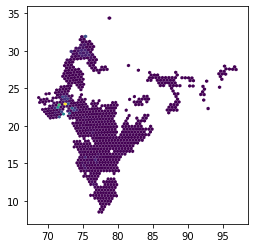

In [34]:
impact_raster = "../../datasets/processed/h3_test/water_impact_cotton_ind_m3yr.tif"

with rio.open(impact_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=4,
        nodata_value=int(src.profile["nodata"]),
        compacted=False,
    )

gdf.plot("value")
# gdf['h3index'] = gdf['h3index'].apply(hex)
gdf.head()

In [36]:
src = rio.open(impact_raster)
window = rio.windows.from_bounds(*test_area, src.transform)

array = src.read(window=window)
impact_df = array[0].ravel()
rst_m = round(impact_df[impact_df > 0].mean(), 3)
rst_s = round(impact_df[impact_df > 0].std(), 3)

h3_m = round(gdf["value"].mean(), 3)
h3_s = round(gdf["value"].std(), 3)

print(f"Raster IMPACT mean value: {rst_m:.3f}  std. dev.:{rst_s:.3f}")
print(f"H3 map IMPACT mean value: {h3_m}   std. dev.:{h3_s}")

Raster IMPACT mean value: 0.008  std. dev.:0.038
H3 map IMPACT mean value: 0.01   std. dev.:0.047


## Convert rasters to H3

### Production

In [37]:
prod_raster = "../../datasets/processed/h3_test/cotton_production_ind.tif"
with rio.open(prod_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)

    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=6,
        nodata_value=int(src.profile["nodata"]),
        compacted=False,
    )

# Cast 'h3index' numeric value as hexadecimal value and set as index
gdf["h3index"] = gdf["h3index"].apply(lambda x: hex(x)[2:])
gdf.index = gdf["h3index"]
gdf.drop(columns="h3index", inplace=True)
gdf

,value,geometry
h3index,,
8642d96dfffffff,1.278079,"POLYGON ((73.54336 20.53316, 73.54348 20.56626..."
86609928fffffff,1.278079,"POLYGON ((73.57195 20.48526, 73.57206 20.51838..."
86609929fffffff,1.278079,"POLYGON ((73.60089 20.53672, 73.60101 20.56983..."
8660aa80fffffff,77.621231,"POLYGON ((75.33760 16.52547, 75.33792 16.55962..."
8660aa857ffffff,77.621231,"POLYGON ((75.27954 16.52388, 75.27986 16.55801..."
...,...,...
863c80a87ffffff,1.280013,"POLYGON ((84.29110 21.23015, 84.29255 21.26491..."
863c80a8fffffff,1.280013,"POLYGON ((84.35548 21.23020, 84.35693 21.26496..."
863c80a9fffffff,1.280013,"POLYGON ((84.32112 21.17803, 84.32257 21.21280..."


Save to GeoJSON

In [65]:
gdf.to_file("../../datasets/processed/h3_test/cotton_production_ind.geojson", driver="GeoJSON")

Save to CSV

In [66]:
gdf.drop("geometry", axis=1).to_csv(
    "../../datasets/processed/h3_test/cotton_production_ind.csv", index=True
)

### Risk

In [38]:
risk_raster = "../../datasets/processed/h3_test/wr_cotton_india.tif"
with rio.open(risk_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)

    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=6,
        nodata_value=int(src.profile["nodata"]),
        compacted=False,
    )

# Cast 'h3index' numeric value as hexadecimal value and set as index
gdf["h3index"] = gdf["h3index"].apply(lambda x: hex(x)[2:])
gdf.index = gdf["h3index"]
gdf.drop(columns="h3index", inplace=True)

gdf.to_file("../../datasets/processed/h3_test/wr_cotton_india.geojson", driver="GeoJSON")
gdf.drop("geometry", axis=1).to_csv(
    "../../datasets/processed/h3_test/wr_cotton_india.csv", index=True
)

### Impact

In [39]:
impact_raster = "../../datasets/processed/h3_test/water_impact_cotton_ind_m3yr.tif"
with rio.open(impact_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)

    gdf = raster.raster_to_geodataframe(
        src.read(1, window=window),
        transform,
        h3_resolution=6,
        nodata_value=int(src.profile["nodata"]),
        compacted=False,
    )

# Cast 'h3index' numeric value as hexadecimal value and set as index
gdf["h3index"] = gdf["h3index"].apply(lambda x: hex(x)[2:])
gdf.index = gdf["h3index"]
gdf.drop(columns="h3index", inplace=True)

gdf.to_file(
    "../../datasets/processed/h3_test/water_impact_cotton_ind_m3yr.geojson", driver="GeoJSON"
)
gdf.drop("geometry", axis=1).to_csv(
    "../../datasets/processed/h3_test/water_impact_cotton_ind_m3yr.csv", index=True
)